## Import libraries

First of all I imported necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import collections
import math
import matplotlib.pyplot as plt

import io
import base64
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

from IPython.display import display
import scipy
from scipy import ndimage
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.preprocessing import image

Using TensorFlow backend.


## Data preprocessing

Then I loaded train and test data set,to which data augmentation was assigned. Data was loaded from Kaggle's data sets: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset. It contains 20 different characters, but for recognizing I chose only 4 characters: Homer, Marge, Lisa and Bart. Also I cutted this data set a little bit for faster model fitting. My train set consists of 809 pictures of each character, and my test set consists of 197 pictures of each character.

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
training_set = train_datagen.flow_from_directory(
    '/home/daria/Documents/cnn/simp_rec/train',
                target_size = (64, 64),
                batch_size = 50,
                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(
    '/home/daria/Documents/cnn/simp_rec/test',
            target_size = (64, 64),
            batch_size = 50,
            class_mode = 'categorical')

Found 3240 images belonging to 4 classes.
Found 792 images belonging to 4 classes.


I used simple structure for Convolutional Neural Networks architecture. Just 2 layers with 32 and 64 filters accordingly. As optimizer I chose 'Adam' optimizer. 

In [5]:
classifier = Sequential()
classifier.add(Conv2D(32,3,3, input_shape = (64,64,3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Conv2D(64,3,3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(output_dim = 128, activation = 'relu'))
classifier.add(Dense(output_dim = 4, activation = 'sigmoid'))
classifier.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Model training

Fitting this simple model took about 20 minutes.

In [ ]:
epochs = 20
train_samples = 3240
validation_samples = 792
batch_size =30
classifier.fit_generator(
        training_set,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=test_set,
        validation_steps=validation_samples// batch_size,)

Saving and loading keras model architecture and weights:

In [ ]:
classifier.save('/home/daria/Documents/cnn/simp_rec/classifier.h5')

In [6]:
classifier = load_model('/home/daria/Documents/cnn/simp_rec/classifier.h5')

## Classifier results

To evaluate model accuracy I used data set that model hasn't seen yet (not test data). 

In [7]:
result = [] 
path = '/home/daria/Documents/cnn/simp_rec/predict' 
files = os.listdir(path)

for file in files: 
    test_image = image.load_img('/home/daria/Documents/cnn/simp_rec/predict/'+file, 
                                               target_size=(64, 64)) 
    test_image = image.img_to_array(test_image) 
    test_image = np.expand_dims(test_image, axis=0)
    
    pred = classifier.predict(test_image)
    result.append(pred)
    
result = np.asarray(result)

Let's display class indices of dependebt variable:

In [8]:
training_set.class_indices

{'bart': 0, 'homer': 1, 'lisa': 2, 'marge': 3}

In folder with test pictures pictures are named as below: 

In [9]:
for i in range(0, 5):
    print(files[i])

marge_simpson_5.jpg
bart_simpson_17.jpg
homer_simpson_40.jpg
bart_simpson_19.jpg
lisa_simpson_33.jpg


So I extracted substrings in strings until '_' and got just names of characters, like: 'marge', 'lisa'...These substrings were used in data frame with results.

In [10]:
for i in range(0, len(files) ):
    files[i] = files[i].split('_')[0]

In [11]:
index = files
import pandas as pd
predictions = result[:, [0]][:,0]
df = pd.DataFrame(index=index)

df['bart'] = predictions[:,0]
df['homer'] = predictions[:,1]
df['lisa'] = predictions[:,2]
df['marge'] = predictions[:,3]

df = df.astype(int)

Frequency of each character in test data set:

In [12]:
counter = collections.Counter(files)
counter

Counter({'marge': 47, 'bart': 49, 'homer': 40, 'lisa': 43})

In [13]:
bart_result = df[(df['bart'] == 1)& (df.index == 'bart')].shape[0]

homer_result = df[(df['homer'] == 1) & (df.index == 'homer')].shape[0]


lisa_result = df[(df['lisa'] == 1) & (df.index == 'lisa')].shape[0]

marge_result = df[(df['marge'] == 1) & (df.index == 'marge')].shape[0]

First 5 rows of result data frame:

In [14]:
df.head()

bart  homer  lisa  marge
marge     0      0     0      1
bart      1      0     0      0
homer     0      1     0      0
bart      1      0     0      0
lisa      0      0     1      0

Accuracy for each character:

In [15]:
print('Bart accuracy:' + ' ' + str(np.round(bart_result/counter['bart'] *100,2)) + str ('%'))
print('Homer accuracy:'+ ' ' + str(np.round(homer_result/counter['homer'] *100,2)) + str ('%'))
print('Lisa accuracy:'+' ' + str(np.round(lisa_result/counter['lisa'] *100,2)) + str ('%'))
print('Marge accuracy:'+ ' ' + str(np.round(marge_result/counter['marge'] *100,2)) + str ('%'))

Bart accuracy: 81.63%
Homer accuracy: 80.0%
Lisa accuracy: 97.67%
Marge accuracy: 91.49%


## Character recognizing on the video

Then I tried recognize characters on video. I found this short video and cutted it for more shorter video where only Homer, Marge, Lisa and Bart appeared. 

In [16]:
video = io.open('/home/daria/Documents/cnn/simp_rec/simpsons.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [17]:
ffmpeg_extract_subclip("/home/daria/Documents/cnn/simp_rec/simpsons.mp4",0,55, 
                       targetname="/home/daria/Documents/cnn/simp_rec/cutted_video.mp4")


[MoviePy] Running:
>>> /home/daria/anaconda3/bin/ffmpeg -y -i /home/daria/Documents/cnn/simp_rec/simpsons.mp4 -ss 0.00 -t 55.00 -vcodec copy -acodec copy /home/daria/Documents/cnn/simp_rec/cutted_video.mp4
... command successful.


From cutted video I extracted frames and exported to new folder. So I received 56 pictures which were got from video. 

In [18]:
count = 0
videoFile = "/home/daria/Documents/cnn/simp_rec/cutted_video.mp4"
cap = cv2.VideoCapture(videoFile) 
frameRate = cap.get(5)
x=1
while(cap.isOpened()):
    frameId = cap.get(1) 
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="/home/daria/Documents/cnn/simp_rec/frames/frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [19]:
from keras.preprocessing import image

For each frame (picture)  text with prediction was putted on the picture.

In [20]:
video_result = [] 
count = 0
path = '/home/daria/Documents/cnn/simp_rec/frames' 
files = os.listdir(path)

for i in range(1,len(files)): 
    test_image = image.load_img('/home/daria/Documents/cnn/simp_rec/frames/'+'frame' +str(i) + '.jpg', 
                                               target_size=(64, 64)) 
    test_image_array = image.img_to_array(test_image) 
    test_image_array = np.expand_dims(test_image_array, axis=0)
    
    result = classifier.predict(test_image_array)
    draw = ImageDraw.Draw(test_image)
    x = y = 0
    if result[0][0] == 1:
        draw.text((x, y), 'Bart', (0, 0, 0))
    elif result[0][1] == 1:
        draw.text((x, y), 'Homer', (0, 0, 0))
    elif result[0][2] == 1:
        draw.text((x, y), 'Lisa', (0, 0, 0))
    elif result[0][3] == 1:
        draw.text((x, y), 'Marge', (0, 0, 0))
        
    count+=1
    test_image.save("/home/daria/Documents/cnn/simp_rec/frames_with_text/frame%d.jpg" % count)
    
print('Done')

Done


Then new pictures with text prediction were loaded.

In [21]:
path = '/home/daria/Documents/cnn/simp_rec/frames_with_text' 
files = os.listdir(path)
image_set= []

for i in range(1,len(files)+1): 
    test_image = image.load_img('/home/daria/Documents/cnn/simp_rec/frames_with_text/'+'frame' +str(i) + '.jpg', 
                                               target_size=(64, 64)) 
    image_set.append(test_image)
print('Done')

Done


And here is a result. It is not so accurate but not so bad to :)

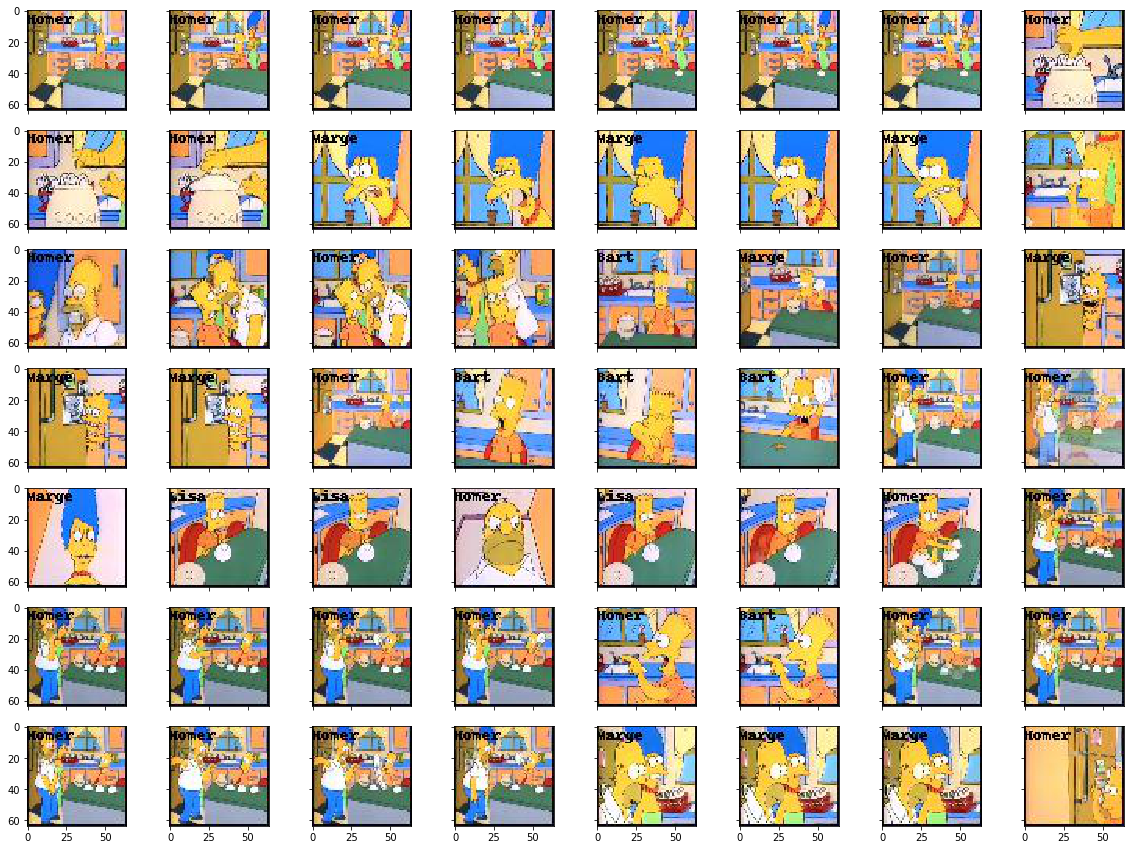

In [22]:
fig, ax = plt.subplots(7,8, sharex='col', sharey='row', figsize=(20,15))

count = 0 
for i in range(7):
    for j in range(8):
        ax[i, j].imshow(image_set[count])
        count+=1
ax;